# HW2: Spam classification with LSTM

The deadline is **9:30 am Feb 18, 2022**.   
You should submit a `.ipynb` file with your solutions to NYU Brightspace.

---

In this homework, we will reuse the spam prediction dataset used in HW1.
We will use a word-level BiLSTM sentence encoder to encode the sentence and a neural network classifier.

For reference, you may read [this paper](https://arxiv.org/abs/1705.02364).

Lab 3 is especially relevant to this homework.

## Points distribution

1. code `spam_collate_func`: 25 pts
2. code `LSTMClassifier.init`: 25 pts
3. code `LSTMClassifier.forward`: 20 pts
4. code `evaluate`: 10 pts
5. code for training loop: 10 pts
6. Question on early stopping: 10 pts

How we grade the code: 
- full points if code works and the underlying logic is correct;
- half points if code works but the underlying logic is incorrect;
- zero points if code does not work.

Therefore, **make sure your code works, i.e., no error is being produced when you execute the code.**


# Data Loading
First, reuse the code from HW1 to download and read the data.

In [ ]:
!wget 'https://docs.google.com/uc?export=download&id=1OVRo37agn02mc6yp5p6-wtJ8Hyb-YMXR' -O spam.csv

'wget' is not recognized as an internal or external command,
operable program or batch file.
'id' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv("spam.csv", usecols=["v1", "v2"], encoding='latin-1')
# 1 - spam, 0 - ham
df.v1 = (df.v1 == "spam").astype("int")
df.head(100)

FileNotFoundError: [Errno 2] No such file or directory: 'spam.csv'

We will split the data into train, val, and test sets.  
`train_texts`, `val_texts`, and `test_texts` should contain a list of text examples in the dataset.


In [ ]:
# 0.15 for val, 0.15 for test, 0.7 for train
val_size = int(df.shape[0] * 0.15)
test_size = int(df.shape[0] * 0.15)

# Shuffle the data
df = df.sample(frac=1)
# Split df to test/val/train
test_df = df[:test_size]
val_df = df[test_size:test_size+val_size]
train_df = df[test_size+val_size:]


train_texts, train_labels = list(train_df.v2), list(train_df.v1)
val_texts, val_labels     = list(val_df.v2), list(val_df.v1)
test_texts, test_labels   = list(test_df.v2), list(test_df.v1)


# Check that idces do not overlap
assert set(train_df.index).intersection(set(val_df.index)) == set({})
assert set(test_df.index).intersection(set(train_df.index)) == set({})
assert set(val_df.index).intersection(set(test_df.index)) == set({})
# Check that all idces are present
assert df.shape[0] == len(train_labels) + len(val_labels) + len(test_labels)

# Sizes
print(
    f"Size of initial data: {df.shape[0]}\n"
    f"Train size: {len(train_labels)}\n"
    f"Val size: {len(val_labels)}\n"
    f"Test size: {len(test_labels)}\n"
)

Size of initial data: 5572
Train size: 3902
Val size: 835
Test size: 835



In [ ]:
train_texts[:10]  # Just checking the examples in train_text

['Fighting with the world is easy, u either win or lose bt fightng with some1 who is close to u is dificult if u lose - u lose if u win - u still lose.',
 'Customer service announcement. We recently tried to make a delivery to you but were unable to do so, please call 07090298926 to re-schedule. Ref:9307622',
 'True lov n care wil nevr go unrecognized. though somone often makes mistakes when valuing it. but they will definitly undrstnd once when they start missing it.',
 'That is wondarfull song',
 'Thanks for your ringtone order, ref number K718. Your mobile will be charged å£4.50. Should your tone not arrive please call customer services on 09065069120',
 'Ups which is 3days also, and the shipping company that takes 2wks. The other way is usps which takes a week but when it gets to lag you may have to bribe nipost to get your stuff.',
 'You have been specially selected to receive a \\3000 award! Call 08712402050 BEFORE the lines close. Cost 10ppm. 16+. T&Cs apply. AG Promo"',
 "Sorry

# Download and Load GloVe Embeddings
We will use GloVe embedding parameters to initialize our layer of word representations / embedding layer.
Let's download and load glove.


This is related Lab 3 Deep Learning, please watch the recording and check the notebook for details.


In [ ]:
#@title Download GloVe word embeddings

# === Download GloVe word embeddings
# !wget http://nlp.stanford.edu/data/glove.6B.zip

# === Unzip word embeddings and use only the top 50000 word embeddings for speed
# !unzip glove.6B.zip
# !head -n 50000 glove.6B.300d.txt > glove.6B.300d__50k.txt

# === Download Preprocessed version
!wget https://docs.google.com/uc?id=1KMJTagaVD9hFHXFTPtNk0u2JjvNlyCAu -O glove_split.aa
!wget https://docs.google.com/uc?id=1LF2yD2jToXriyD-lsYA5hj03f7J3ZKaY -O glove_split.ab
!wget https://docs.google.com/uc?id=1N1xnxkRyM5Gar7sv4d41alyTL92Iip3f -O glove_split.ac
!cat glove_split.?? > 'glove.6B.300d__50k.txt'

--2022-02-24 15:31:23--  https://docs.google.com/uc?id=1KMJTagaVD9hFHXFTPtNk0u2JjvNlyCAu
Resolving docs.google.com (docs.google.com)... 173.194.76.102, 173.194.76.101, 173.194.76.100, ...
Connecting to docs.google.com (docs.google.com)|173.194.76.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-0g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/thqj724rh7fb66ov4u84d1nm4580vocf/1645716675000/14514704803973256873/*/1KMJTagaVD9hFHXFTPtNk0u2JjvNlyCAu [following]
--2022-02-24 15:31:28--  https://doc-0k-0g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/thqj724rh7fb66ov4u84d1nm4580vocf/1645716675000/14514704803973256873/*/1KMJTagaVD9hFHXFTPtNk0u2JjvNlyCAu
Resolving doc-0k-0g-docs.googleusercontent.com (doc-0k-0g-docs.googleusercontent.com)... 74.125.71.132, 2a00:1450:400c:c02::84
Connecting to doc-0k-0g-docs.googleusercontent.com (doc-0k-0g-docs.googleusercontent.com)|74.125.71.132|:443..

In [ ]:
!wget https://campuspro-uploads.s3.us-west-2.amazonaws.com/f14e42f6-0f57-4d3c-bf3c-6eb8982c822b/1447cf92-9ef5-4097-939d-f69337174ded/glove.6B.300d__50k.txt.zip
!unzip glove.6B.300d__50k.txt.zip

--2022-02-24 15:31:37--  https://campuspro-uploads.s3.us-west-2.amazonaws.com/f14e42f6-0f57-4d3c-bf3c-6eb8982c822b/1447cf92-9ef5-4097-939d-f69337174ded/glove.6B.300d__50k.txt.zip
Resolving campuspro-uploads.s3.us-west-2.amazonaws.com (campuspro-uploads.s3.us-west-2.amazonaws.com)... 52.218.178.89
Connecting to campuspro-uploads.s3.us-west-2.amazonaws.com (campuspro-uploads.s3.us-west-2.amazonaws.com)|52.218.178.89|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49335722 (47M) [application/zip]
Saving to: ‘glove.6B.300d__50k.txt.zip’

glove.6B.300d__50k. 100%[===================>]  47.05M  14.3MB/s    in 3.7s    

2022-02-24 15:31:41 (12.6 MB/s) - ‘glove.6B.300d__50k.txt.zip’ saved [49335722/49335722]

Archive:  glove.6B.300d__50k.txt.zip
replace glove.6B.300d__50k.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
  inflating: __MACOSX/._glove.6B.300d__50k.txt  


## Load GloVe Embeddings

In [ ]:
def load_glove(glove_path, embedding_dim):
    with open(glove_path) as f:
        token_ls = [PAD_TOKEN, UNK_TOKEN]
        embedding_ls = [np.zeros(embedding_dim), np.random.rand(embedding_dim)]
        for line in f:
            token, raw_embedding = line.split(maxsplit=1)
            token_ls.append(token)
            embedding = np.array([float(x) for x in raw_embedding.split()])
            embedding_ls.append(embedding)
        embeddings = np.array(embedding_ls)
        print(embedding_ls[-1].size)
    return token_ls, embeddings

PAD_TOKEN = '<PAD>'
UNK_TOKEN = '<UNK>'
EMBEDDING_DIM = 300 # dimension of Glove embeddings
glove_path = "glove.6B.300d__50k.txt"
vocab, embeddings = load_glove(glove_path, EMBEDDING_DIM)

300


## Import packages

In [ ]:
!pip install sacremoses

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import os
import pandas as pd
import sacremoses
from torch.utils.data import dataloader, Dataset
from tqdm.auto import tqdm

     |████████████████████████████████| 895 kB 11.1 MB/s 


# Tokenize text data.
We will use the `tokenize` function to convert text data into sequence of indices.

In [ ]:
def tokenize(data, labels, tokenizer, vocab, max_seq_length=128):
    vocab_to_idx = {word: i for i, word in enumerate(vocab)}
    text_data = []
    label_data = []
    for ex in tqdm(data):
        tokenized = tokenizer.tokenize(ex.lower())
        ids = [vocab_to_idx.get(token, 1) for token in tokenized]
        text_data.append(ids)
    return text_data, labels
tokenizer = sacremoses.MosesTokenizer()
train_data_indices, train_labels = tokenize(train_texts, train_labels, tokenizer, vocab)
val_data_indices, val_labels = tokenize(val_texts, val_labels, tokenizer, vocab)
test_data_indices, test_labels = tokenize(test_texts, test_labels, tokenizer, vocab)

  0%|          | 0/3902 [00:00<?, ?it/s]

  0%|          | 0/835 [00:00<?, ?it/s]

  0%|          | 0/835 [00:00<?, ?it/s]

In [ ]:
print("\nTrain text first 5 examples:\n", train_data_indices[:5])
print("\nTrain labels first 5 examples:\n", train_labels[:5])


Train text first 5 examples:
 [[800, 19, 2, 87, 16, 1675, 3, 6481, 902, 322, 48, 1897, 7671, 1, 19, 1, 40, 16, 385, 6, 6481, 16, 1, 85, 6481, 1897, 13, 6481, 1897, 85, 6481, 322, 13, 6481, 151, 1897, 4], [4190, 272, 1, 55, 746, 979, 6, 161, 9, 2765, 6, 83, 36, 37, 2284, 6, 90, 102, 3, 3834, 582, 1, 6, 1, 29128, 47, 1], [1448, 1, 3816, 759, 39304, 1, 244, 1, 415, 1, 458, 909, 4918, 63, 33527, 1, 36, 41, 45, 1, 1, 444, 63, 41, 467, 1512, 22, 4], [14, 16, 1, 815], [3126, 12, 394, 1, 462, 3, 29128, 225, 1, 394, 2374, 45, 32, 1264, 1, 4552, 1, 191, 394, 4447, 38, 3706, 3834, 582, 4190, 524, 15, 1]]

Train labels first 5 examples:
 [0, 1, 0, 0, 1]


# Create DataLoaders (25 pts)
 Now, let's create pytorch DataLoaders for our train, val, and test data.

 `SpamDataset` class is based on torch [`Dataset`](https://pytorch.org/docs/1.7.0/data.html?highlight=dataset#torch.utils.data.Dataset). It has an additional parameter called `self.max_sent_length` and a `spam_collate_func`.

In order to use batch processing, all the examples need to effectively be the same length. We'll do this by adding padding tokens. `spam_collate_func` is supposed to dynamically pad or trim the sentences in the batch based on `self.max_sent_length` and the length of longest sequence in the batch. 
- If `self.max_sent_length` is less than the length of longest sequence in the batch, use `self.max_sent_length`. Otherwise, use the length of longest sequence in the batch.
- We do this because our input sentences in the batch may be much shorter than `self.max_sent_length`.  

Please check the comment block in the code near TODO for more details.


Example: 

* PAD token id = 0
* max_sent_length = 5

input list of sequences:
```
inp = [
    [1,4,5,3,5,6,7,4,4],
    [3,5,3,2],
    [2,5,3,5,6,7,4],
]
```
then padded minibatch looks like this:
```
padded_input = 
    [[1,4,5,3,5],
     [3,5,3,2,0],
     [2,5,3,5,6]]
```

In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset

class SpamDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list, max_sent_length=128):
        """
        @param data_list: list of data tokens 
        @param target_list: list of data targets 
        """
        self.data_list = data_list
        self.target_list = target_list
        self.max_sent_length = max_sent_length
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key, max_sent_length=None):
        """
        Triggered when you call dataset[i]
        """
        if max_sent_length is None:
            max_sent_length = self.max_sent_length
        token_idx = self.data_list[key][:max_sent_length]
        label = self.target_list[key]
        return [token_idx, label]

    def spam_collate_func(self, batch):
        """
        Customized function for DataLoader that dynamically pads the batch so that all 
        data have the same length
        # What the input `batch`? That's for you to figure out!
        # You can read the Dataloader documentation, or you can use print
        # function to debug. 
        """ 
        data_list = [] # store padded sequences
        label_list = []

        longest_seq_len = 0
        for entry in batch:
          if len(entry[0]) > longest_seq_len:
            longest_seq_len = len(entry[0])

        max_batch_seq_len = longest_seq_len if longest_seq_len < self.max_sent_length else self.max_sent_length
                            # the length of longest sequence in batch
                            # if it is less than self.max_sent_length
                            # else max_batch_seq_len = self.max_sent_length

        """
          # Pad the sequences in your data
          # if their length is less than max_batch_seq_len
          # or trim the sequences that are longer than self.max_sent_length
          # return padded data_list and label_list
          1. TODO: Your code here
        """

        for entry in batch:
          if len(entry[0]) < max_batch_seq_len:
            zeros = np.zeros(max_batch_seq_len - len(entry[0]))
            temp = np.concatenate((entry[0], zeros), axis=None)
          else:
            temp = entry[0][:max_batch_seq_len]

          data_list.append(temp)
          label_list.append(entry[1])

        data_list = torch.tensor(data_list)
        label_list = torch.tensor(label_list)
        data_label = [data_list, label_list]

        return data_label

BATCH_SIZE = 64
max_sent_length=128
train_dataset = SpamDataset(train_data_indices, train_labels, max_sent_length)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=train_dataset.spam_collate_func,
                                           shuffle=True)

val_dataset = SpamDataset(val_data_indices, val_labels, train_dataset.max_sent_length)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=train_dataset.spam_collate_func,
                                           shuffle=False)

test_dataset = SpamDataset(test_data_indices, test_labels, train_dataset.max_sent_length)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=train_dataset.spam_collate_func,
                                           shuffle=False)

Let's try to print out an batch from train_loader.


In [ ]:
data_batch, labels = next(iter(train_loader))
print("data batch dimension: ", data_batch.size())
print("data_batch: ", data_batch)
print("labels: ", labels)

data batch dimension:  torch.Size([64, 42])
data_batch:  tensor([[4.1700e+02, 3.6523e+04, 4.7000e+01,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.2100e+02, 8.3000e+01, 1.7100e+02,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.9900e+02, 3.4000e+01, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [1.7100e+02, 3.1600e+02, 5.5370e+03,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [9.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [4.8640e+03, 4.0000e+00, 4.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]], dtype=torch.float64)
labels:  tensor([1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


# Build a BiLSTM Classifier (20 + 25 + 10 pts)

Now we are going to build a BiLSTM classifier. Check this [blog post](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) and [`torch.nn.LSTM`](https://pytorch.org/docs/stable/nn.html?highlight=lstm#torch.nn.LSTM) for reference. Recall that we've also seen LSTM in Lab 3. 

The hyperparameters for LSTM are already given, but they are not necessarily optimal. You should get a good accuracy with these hyperparameters but you may try to tune the hyperparameters and use different hyperparameters to get better performance.

* `__init__`: Class constructor. Here we define layers / parameters of LSTM.
* `forward`: This function is used whenever you call your object as `model()`. It takes the input minibatch and returns the output representation from LSTM.

In [ ]:
# First import torch related libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

class LSTMClassifier(nn.Module):
    """
    LSTMClassifier classification model
    """
    
    def __init__(self, embeddings, hidden_size, num_layers, num_classes, bidirectional, dropout_prob=0.3):
        super().__init__()
        self.embedding_layer = self.load_pretrained_embeddings(embeddings)

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_classes = num_classes
        self.bidirectional = bidirectional

        self.dropout = nn.Dropout(p=dropout_prob)
        self.non_linearity = nn.ReLU()
        self.lstm = nn.LSTM(input_size = EMBEDDING_DIM, hidden_size = self.hidden_size, 
                            num_layers = self.num_layers, batch_first=True, dropout=dropout_prob, bidirectional=self.bidirectional)
        
        self.map = {True: 2,
                    False: 1}

        self.clf = nn.Linear(self.map[bidirectional] * self.hidden_size, self.num_classes)

        """
           Define the components of your BiLSTM Classifier model
           2. TODO: Your code here
        """
        # raise NotImplementedError  # delete this line
    
    def load_pretrained_embeddings(self, embeddings):
        """
           The code for loading embeddings from Lab 3 Deep Learning
           Unlike lab, we are not setting `embedding_layer.weight.requires_grad = False`
           because we want to finetune the embeddings on our data
        """
        embedding_layer = nn.Embedding(embeddings.shape[0], embeddings.shape[1], padding_idx=0)
        embedding_layer.weight.data = torch.Tensor(embeddings).float()
        return embedding_layer

    def forward(self, inputs):
        """
           Write forward pass for LSTM. You must use dropout after embedding
           the inputs. 

           Example, forward := embedding -> bilstm -> pooling (sum?mean?max?) 
                              nonlinearity -> classifier
           Refer to: https://arxiv.org/abs/1705.02364

           Return logits

           3. TODO: Your code here
        """

        out = self.dropout(self.embedding_layer(inputs))
        out, _ = self.lstm(out, None) # Batch Size, Time Step, Hidden Size 
        out = out.mean(1)
        out = self.non_linearity.out(out)
        out = self.clf(out) # Missing [:,-1,:]

        return out
''' This is my code from the original Homework 2
    def forward(self, inputs):
        """
           Write forward pass for LSTM. You must use dropout after embedding
           the inputs. 

           Example, forward := embedding -> bilstm -> pooling (sum?mean?max?) 
                              nonlinearity -> classifier
           Refer to: https://arxiv.org/abs/1705.02364

           Return logits

           3. TODO: Your code here
        """

        embedded = self.embedding_layer(inputs)
        out, _ = self.lstm(embedded, None)
        out = self.clf(out[:,-1,:])

        return out
'''
'''
    def forward(self, inputs):
        premise_embed = self.embedding_layer(inputs.premise)
        hypothesis_embed = self.embedding_layer(inputs.hypothesis)

        premise_out, (premise_ht, _) = self.lstm(premise_embed, None)
        hypothesis_out, (hypothesis_ht, _) = self.lstm(hypothesis_embed, None)

        premise = premise_out[:, -1, :]
        hypothesis = hypothesis_out[:, -1, :]

        combined = torch.cat(
                   (premise,  # Q: shape? A: batch_size * (num_directions * hidden_size)
                   hypothesis,  # Q: shape?
                   torch.abs(premise - hypothesis),
                   premise * hypothesis),  # Q: shape?
                   1)

        return self.layers(combined)
'''

'\n    def forward(self, inputs):\n        premise_embed = self.embedding_layer(inputs.premise)\n        hypothesis_embed = self.embedding_layer(inputs.hypothesis)\n\n        premise_out, (premise_ht, _) = self.lstm(premise_embed, None)\n        hypothesis_out, (hypothesis_ht, _) = self.lstm(hypothesis_embed, None)\n\n        premise = premise_out[:, -1, :]\n        hypothesis = hypothesis_out[:, -1, :]\n\n        combined = torch.cat(\n                   (premise,  # Q: shape? A: batch_size * (num_directions * hidden_size)\n                   hypothesis,  # Q: shape?\n                   torch.abs(premise - hypothesis),\n                   premise * hypothesis),  # Q: shape?\n                   1)\n\n        return self.layers(combined)\n'

First, we will define an evaluation function that will return the accuracy of the model. We will use this to compute validation accuracy and test accuracy of the model given a dataloader.

In [ ]:
def evaluate(model, dataloader, device):
    accuracy = None
    model.eval()
    """
        4. TODO: Your code here
        Calculate the accuracy of the model on the data in dataloader
        You may refer to `run_inference` function from Lab 3 part 1.
    """
    with torch.no_grad():
        all_preds = []
        all_labels = []
        for batch_text, batch_labels in dataloader:
            preds = model(batch_text.to(device).long()) ## Had to change from .to(device) to .to(device).long()
            # labels = model(batch_labels.to(device).long()) ## Had to change from .to(device) to .to(device).long()

            all_preds.append(preds.detach().cpu().numpy())
            all_labels.append(batch_labels)

    preds = np.concatenate(all_preds, axis=0)
    labels = np.concatenate(all_labels, axis=0)

    print('<======================Start Test<======================>')
    print(labels)
    print(preds)
    print(preds.argmax(-1))
    print(labels == preds.argmax(-1))
    print((labels == preds.argmax(-1)).mean())
    print('<======================End Test======================>')
    return (labels == preds.argmax(-1)).mean() ## How does this work?

# Initialize the BiLSTM classifier model, criterion and optimizer


In [ ]:
# BiLSTM hyperparameters
hidden_size = 32
num_layers = 1
num_classes = 2
bidirectional = True
torch.manual_seed(1234)

# if cuda exists, use cuda, else run on cpu
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device('cpu')

model = LSTMClassifier(embeddings, hidden_size, num_layers, num_classes, bidirectional)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


# Train model with early stopping (10 pts)

Train the model for `NUM_EPOCHS`. 
Keep track of training loss.  
Compute the validation accuracy after each epoch. Keep track of the best validation accuracy and save the model with the best validation accuracy.  

If the validation accuracy does not improve for more than `early_stop_patience` number of epochs in a row, stop training. 


In [ ]:
train_loss_history = []
val_accuracy_history = []
best_val_accuracy = 0
n_no_improve = 0
early_stop_patience = 2
NUM_EPOCHS = 10
  
for epoch in tqdm(range(NUM_EPOCHS)):
    model.train()  # this enables dropout/regularization
    for i, (data_batch, batch_labels) in enumerate(train_loader):
        """
           Code for training lstm
           Keep track of training of for each batch using train_loss_history
        """
        preds = model(data_batch.to(device).long()) ## Had to change from .to(device) to .to(device).long()
        loss = criterion(preds, batch_labels.to(device).long()) ## Had to change from .to(device) to .to(device).long()
        """
          5(1). TODO: Recall that pytorch training involves five critical
          components, as discussed in the Lab. Some of the components are
          still missing here. Your code here.
        """
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss_history.append(loss.item())
        
    # The end of a training epoch 

    """
        Code for tracking best validation accuracy, saving the best model, and early stopping
        # Compute validation accuracy after each training epoch using `evaluate` function
        # Keep track of validation accuracy in `val_accuracy_history`
        # save model with best validation accuracy, hint: torch.save(model, 'best_model.pt')
        # Early stopping: 
        # stop training if the validation accuracy does not improve for more than `early_stop_patience` runs
        5(2). TODO: Your code here
    """
    val_accuracy = evaluate(model, val_loader, device)

    if val_accuracy > best_val_accuracy:
      best_val_accuracy = val_accuracy
      torch.save(model, 'best_model.pt')

    if len(val_accuracy_history) > 0 and val_accuracy <= val_accuracy_history[-1]:
      n_no_improve += 1
    else:
      n_no_improve = 0

    val_accuracy_history.append(val_accuracy)
    
    if n_no_improve == early_stop_patience:
      break

    # raise NotImplementedError  # delete this line

print("Best validation accuracy is: ", best_val_accuracy)

  0%|          | 0/10 [00:00<?, ?it/s]

Start Test
[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0
 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0
 0 1 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1
 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0
 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0

#Question: Why do we want to use early stopping? Write the most important reason in concise way. (10 pts)

Your answer: Early stopping is used to prevent overfitting, to stop the number of epochs fitting coefficients at a result where the cost function of the validation set does not increase again (as shown below).

<img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2020-05-28_at_12.59.56_PM_1D7lrVF.png" alt="Early Stopping" />


# Draw training curve 
X-axis: training steps, Y-axis: training loss

Make sure to draw your own curves. 

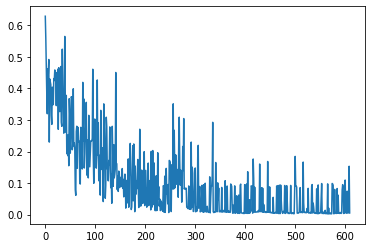

In [ ]:
pd.Series(train_loss_history).plot()

# Validation accuracy curve
X-axis: Epochs, Y-axis: validation accuracy

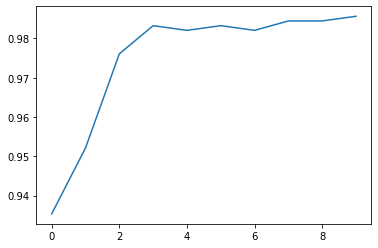

In [ ]:
pd.Series(val_accuracy_history).plot()

## You should expect to get test accuracy > 0.95.

In [ ]:
# Reload best model from saved checkpoint
# Compute test accuracy
model = torch.load('best_model.pt')
test_accuracy = evaluate(model, test_loader, device)
print('Test accuracy:', test_accuracy)

Start Test
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1
 0 0 0 1 1 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 1 1
 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 1 0 1
 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0
 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0
 1 1 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1